<a href="https://colab.research.google.com/github/msamunetogetoge/masamune/blob/master/Hessian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 簡単なニューラルネットの作成

In [0]:
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt 
import pandas as pd
np.random.seed(0)

In [0]:
from scipy.special import expit as sigmoid
class Sigmoid:
    def forward(self,x):
        sig = sigmoid(x)
        return sig

In [0]:
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b     
        self.x = None
        self.original_x_shape = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        out = np.dot(self.x, self.W) + self.b

        return out

In [0]:
def numerical_gradient(f, x):
    h = 1e-4 
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

In [0]:
def MSE(y,pred):
    N=len(y)
    mse = np.sum( ( y- pred )**2)/N
    return mse
    

In [0]:
#隠れ層1つのニューラルネットワーク
#ヘッシアンの計算は別の関数でする
class SimpleNet:
    def __init__(self, input_size,hidden_size, output_size=1):
        self.params = {}
        self.params['W1'] = np.random.randn(input_size, hidden_size,)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = np.random.randn(hidden_size,output_size)
        self.params['b2'] = np.zeros(output_size)   
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Acrivation'] = Sigmoid()
        self.layers["Affine2"] = Affine(self.params['W2'], self.params['b2'])
        self.grads={}
        self.hessian={}
        

    def predict(self,x):
        for L in self.layers.values():
            x=L.forward(x)
        return x

    def grad(self, x,y):
        func=lambda W: self.loss(x,y)
        for W in self.params.keys():
            shape=self.params[W].shape
            self.grads[W]=numerical_gradient(func,self.params[W]).reshape(shape)
        return self.grads         

    def loss(self,x,y):
        pred = self.predict(x)
        L =- MSE(y,pred)
        
        return L  
    def update_layers(self):
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Acrivation'] = Sigmoid()
        self.layers["Affine2"] = Affine(self.params['W2'], self.params['b2'])       


    def learning(self,x,y,lr,itr):
        self.update_layers()
        self.loss_values = []
        for i in range(itr):
            for key in self.params.keys():
                self.params[key] += lr * self.grad(x,y)[key]
            self.loss_values.append(self.loss(x,y))
        return self.loss_values

In [0]:
NN=SimpleNet(input_size=3,hidden_size=5,output_size=1)

y=sin x でニューラルネットワークが上手く動くか確認

In [0]:
df=pd.DataFrame()
df["x"]=np.linspace(0,3,num=1000)
df["x^2"]=df.x**2
df["x^3"]=df.x**3
df["sin"]= np.sin(df.x)

In [0]:
X=np.array(df[["x","x^2","x^3"]]).reshape(-1,3)
y=np.array(df.sin).reshape(-1,1)

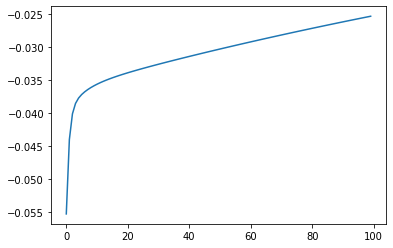

In [19]:
losses=NN.learning(X,y,0.05,100)
plt.plot(losses)

# ヘッシアンの計算

ヘッシアンを同じ変数での2回微分と、別々の変数での微分のブロックに分けて計算する

In [0]:
import copy
import itertools
def Hessian(NN):
    keys = NN.params.keys()
    h=1e-8
    #2種類の変数による微分
    for params in itertools.combinations(keys, 2):
        name = "".join(params)
        NN.hessian[name]=np.array([])
        Hess=np.array([])
        shape= NN.params[params[0]].shape
        N=np.prod(shape)
        M=np.prod(NN.params[params[1]].shape)
        for i in range(N):
            NN_1=copy.deepcopy(NN)
            params_0= NN_1.params[params[0]]
            params_0=params_0.reshape(-1,1)
            params_0[i]-=h
            params_0=params_0.reshape(shape)
            NN_1.update_layers()
            H=(NN.grad(X,y)[params[1]] - NN_1.grad(X,y)[params[1]] )/h
            Hess= np.append(Hess,H)
        Hess=Hess.reshape(N,M)
        NN.hessian[name]=Hess
    #同じ変数による微分    
    for param in keys:
        name = param + param
        NN.hessian[name]=np.array([])
        Hess=np.array([])
        shape= NN.params[param].shape
        N=np.prod(shape)
        for i in range(N):
            NN_1=copy.deepcopy(NN)
            W= NN_1.params[param]
            W=W.reshape(-1,1)
            W[i]-=h
            W=W.reshape(shape)
            NN_1.update_layers()
            H=(NN.grad(X,y)[param] - NN_1.grad(X,y)[param] )/h
            Hess= np.append(Hess,H)
        Hess=Hess.reshape(N,N)
        NN.hessian[name]=Hess
    print("Calculated Hessian")
   

In [33]:
Hessian(NN)

Calculated Hessian


気合でブロックを一つの行列にする

In [0]:
H=np.block(
[[NN.hessian["W1W1"],NN.hessian["W1b1"],NN.hessian["W1W2"],NN.hessian["W1b2"]  ],
[ NN.hessian["W1b1"].T,NN.hessian["b1b1"],NN.hessian["b1W2"],NN.hessian["b1b2"]  ],
[NN.hessian["W1W2"].T,NN.hessian["b1W2"].T,NN.hessian["W2W2"],NN.hessian["W2b2"] ],
[NN.hessian["W1b2"].T,NN.hessian["b1b2"].T,NN.hessian["W2b2"].T,NN.hessian["b2b2"] ]
])

In [35]:
H[:5,:5]

array([[-0.06158268, -0.00579224,  0.0017937 , -0.00204003,  0.00312944],
       [-0.00578877, -0.01451096,  0.00250321, -0.00235749,  0.00623286],
       [ 0.0017937 ,  0.00250321,  0.00023766,  0.00051174, -0.00118655],
       [-0.00204003, -0.00235922,  0.00050654, -0.0017434 ,  0.00112237],
       [ 0.00312597,  0.00623113, -0.00118482,  0.00112757, -0.0020782 ]])

対称行列になってるっぽいので計算出来てる。
差分の取り方を中央差分にしたり、1階微分の精度を上げれば、もっと精度よく対称行列になる。
ヘッシアンはニュートン法とか、ラプラス近似で使う。